Stepping simulation:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3515/3600 [00:54<00:01, 67.64it/s]Event: Maximum voltage [V], Batteries: [0, 1, 2, 3, 4, 5]
High voltage limit reached
Stepping simulation:   0%|                                                                                                                     | 0/600 [00:00<?, ?it/s]High voltage limit reached
Event: Maximum voltage [V], Batteries: [0, 1, 2, 3, 4, 5]
Stepping simulation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 64.34it/s]


Last State of Charge (SoC) value: 99.35%
Shape of local_voltage: (5740, 6)


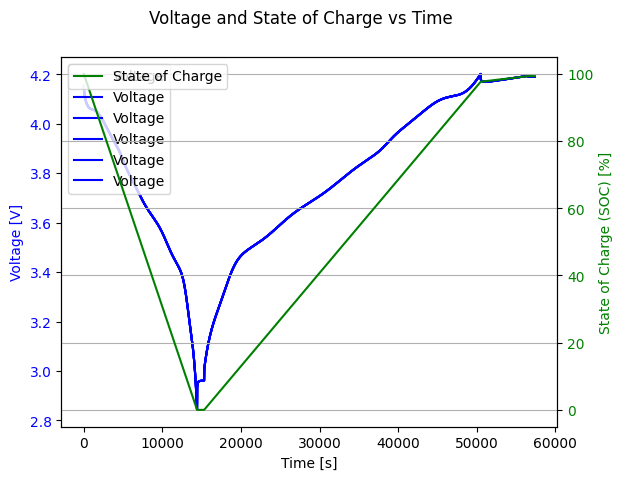

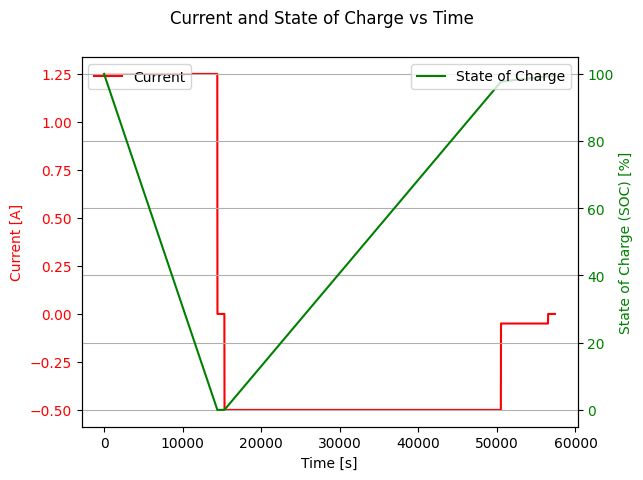

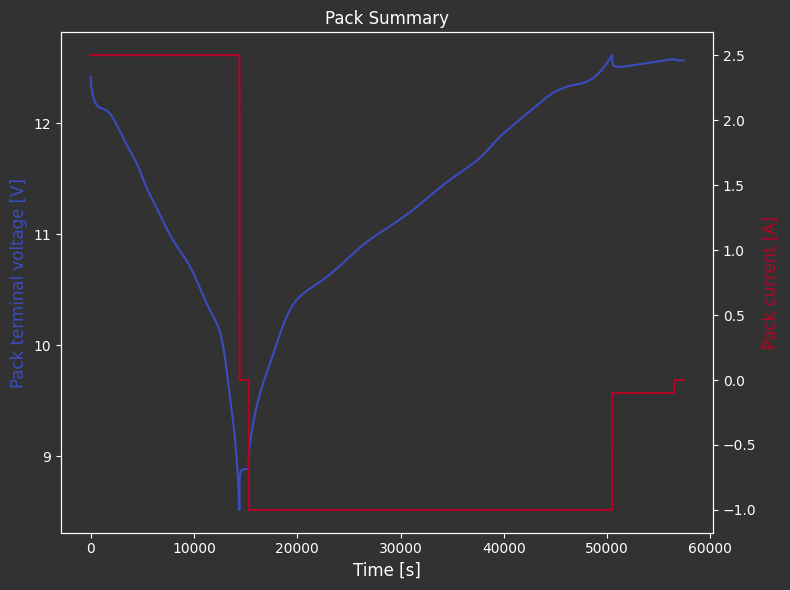

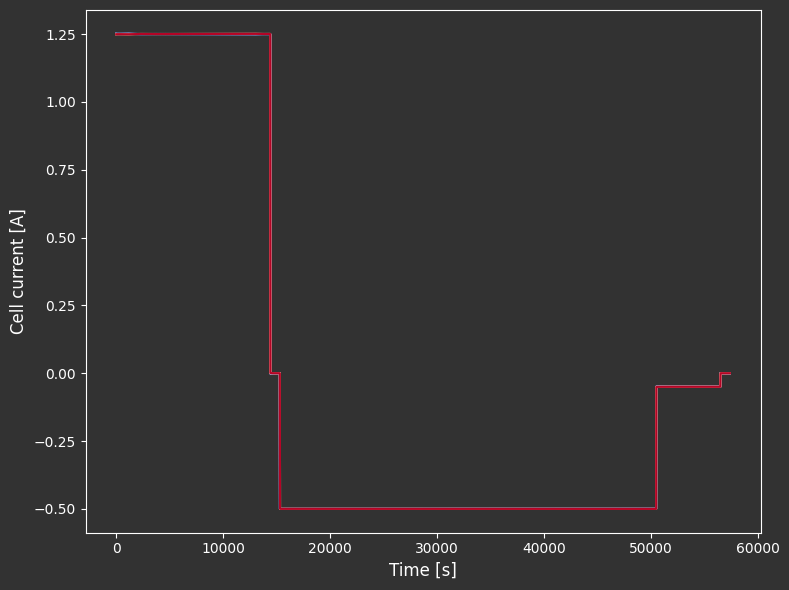

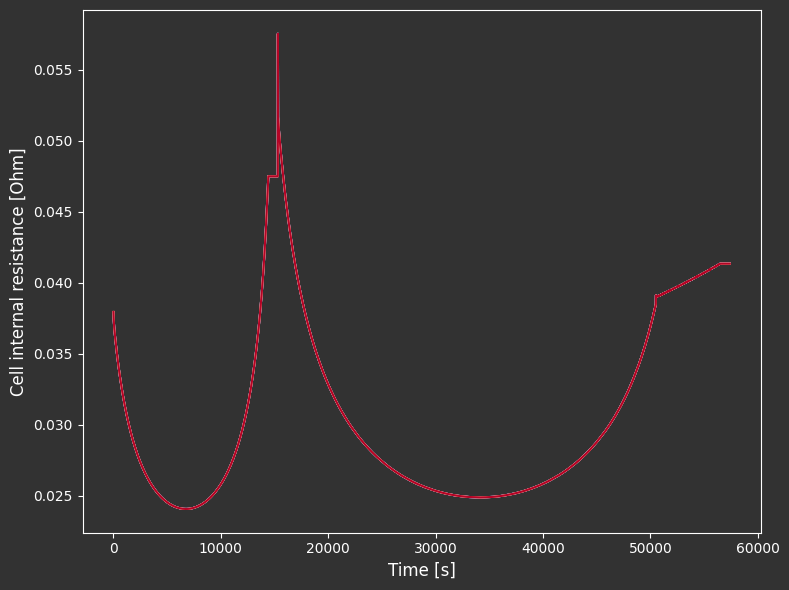

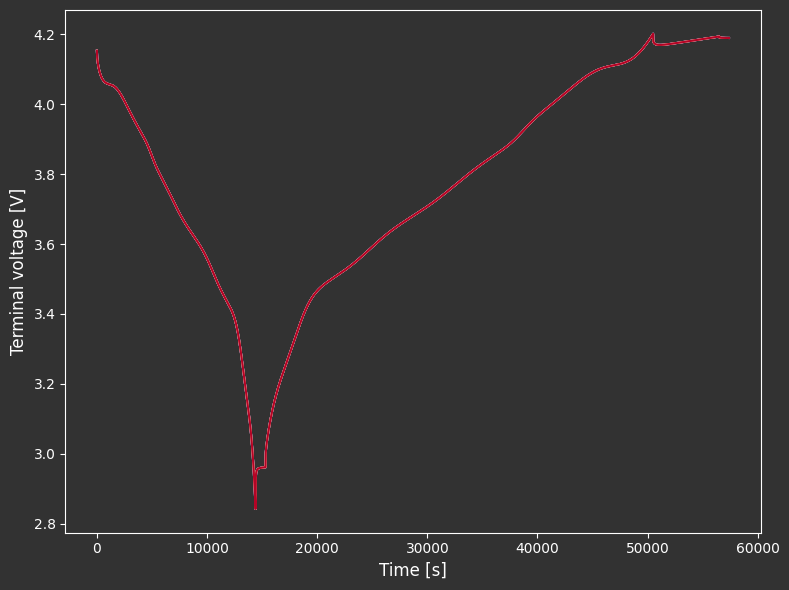

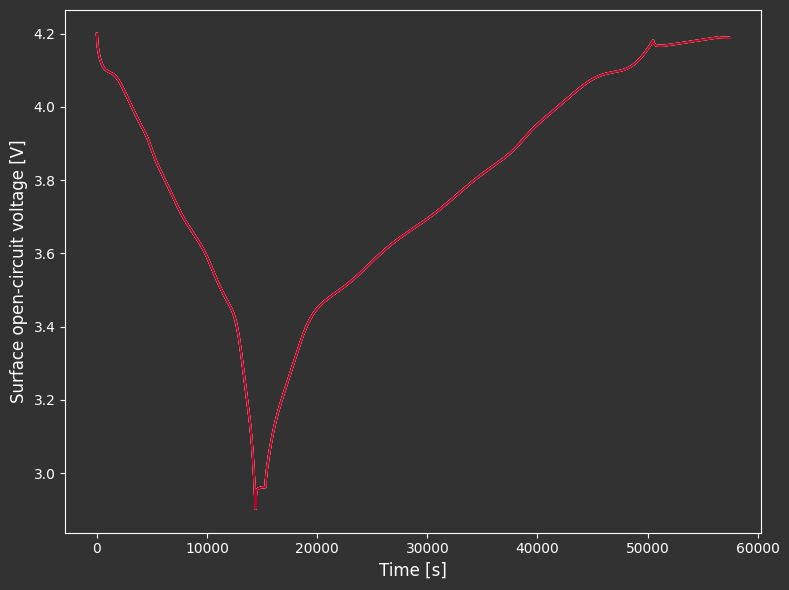

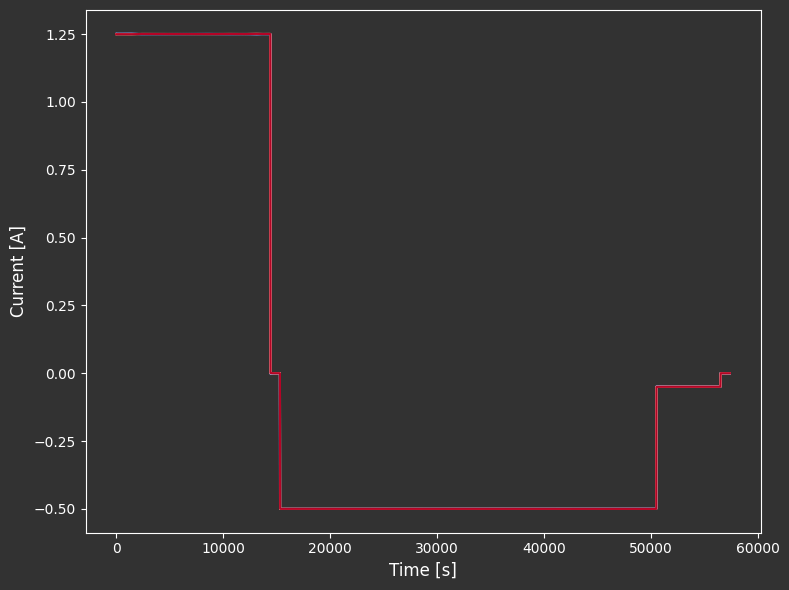

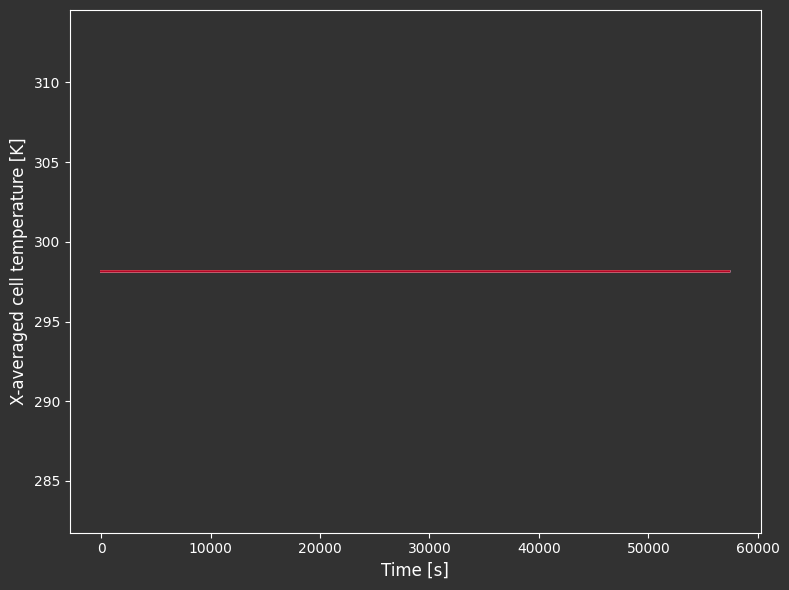

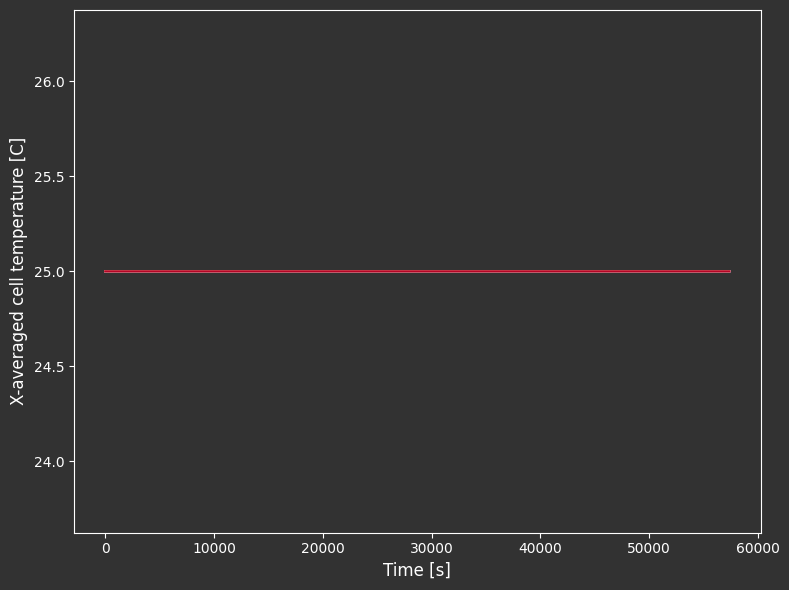

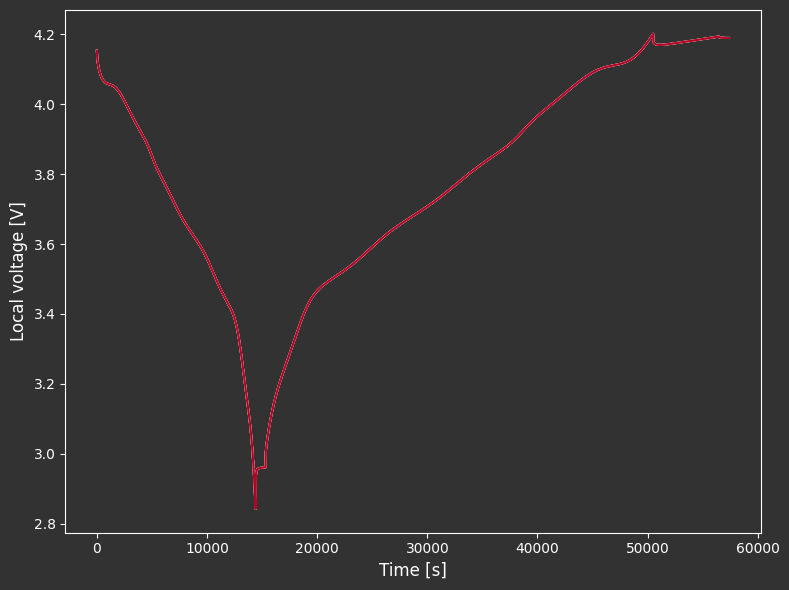

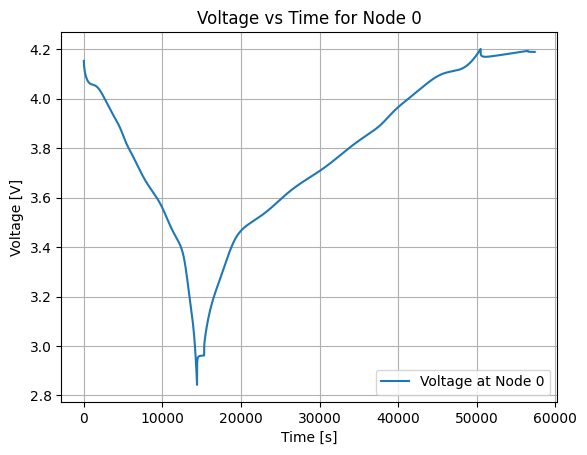

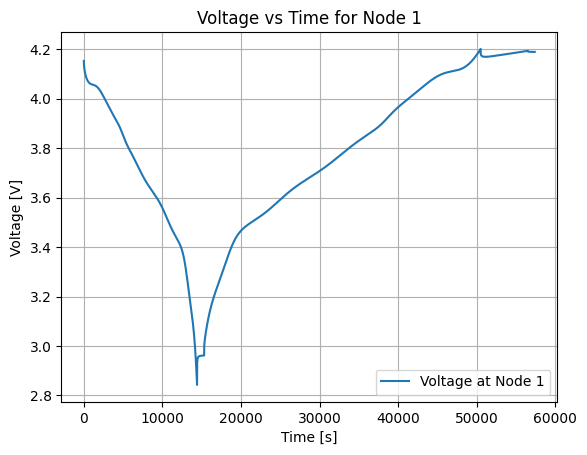

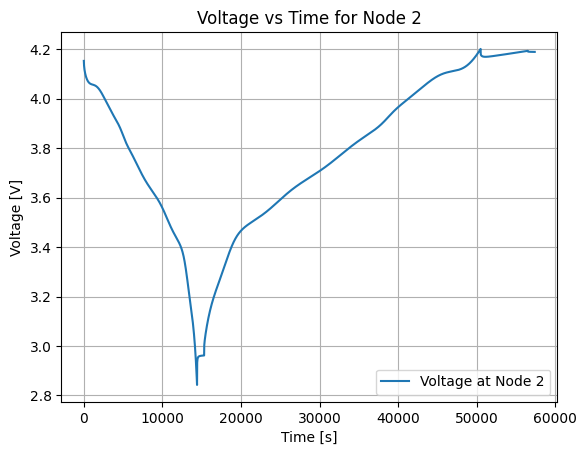

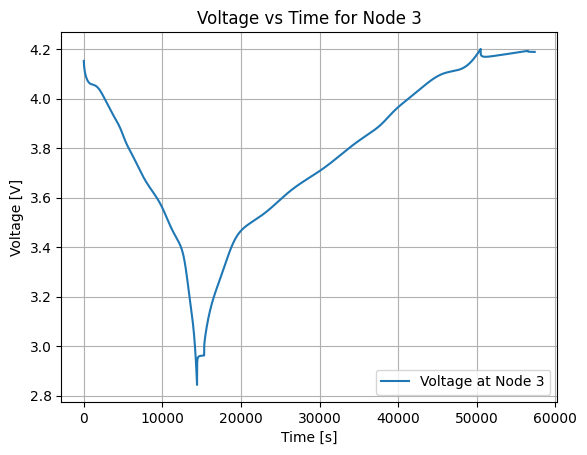

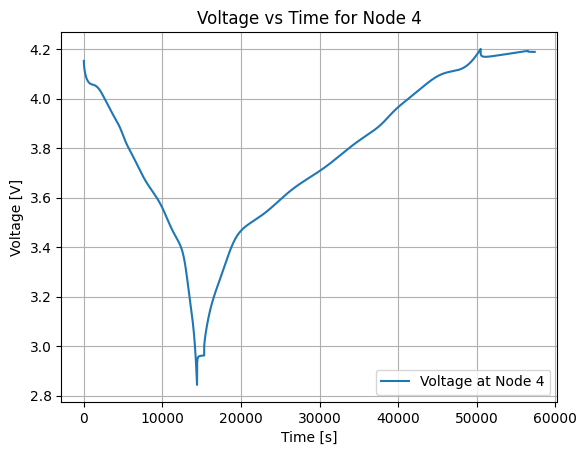

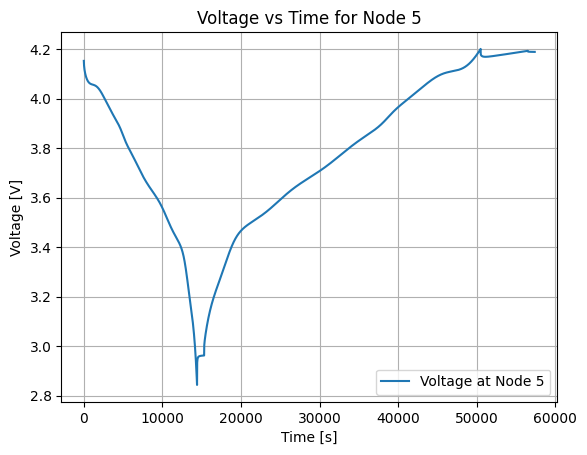

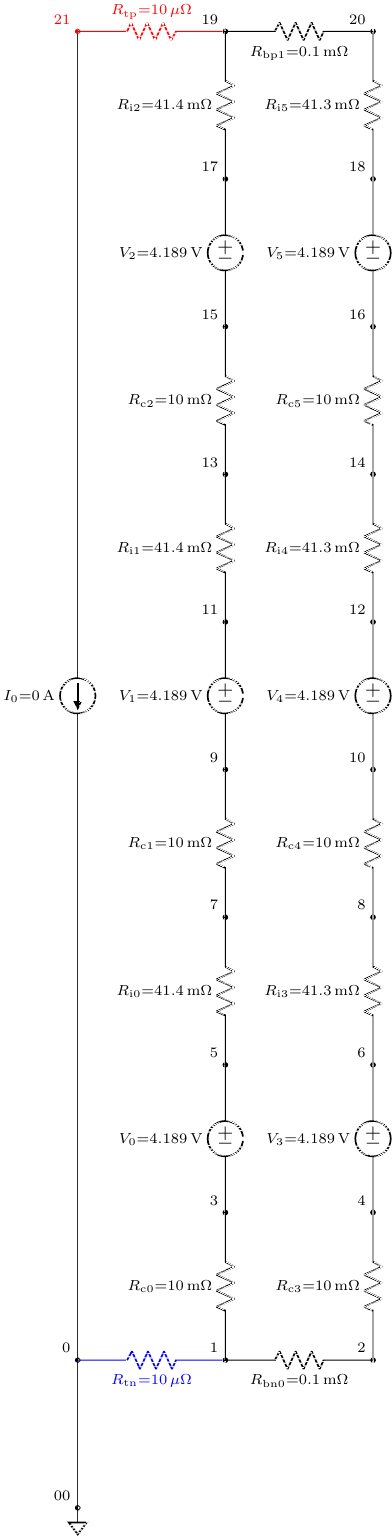

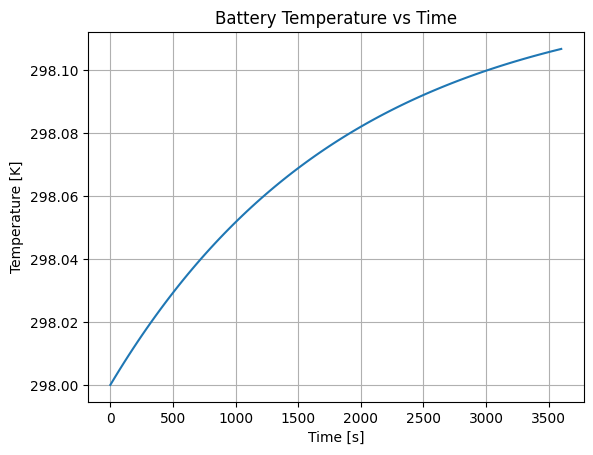

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pybamm
import liionpack as lp

# Parameters for the heat transfer model
I = 1.0  # Current in Amperes
R_internal = 0.05  # Internal resistance in Ohms
h_tc = 20.0  # Heat transfer coefficient in W/m²·K
A = 0.02  # Surface area in m²
C_p = 750  # Heat capacity in J/kg·K
T_ambient = 298  # Ambient temperature in K
T_initial = 298  # Initial battery temperature in K

# Differential equation for the heat transfer model
def dT_dt(T, t):
    Q_generation = I**2 * R_internal
    Q_loss = h_tc * A * (T - T_ambient)
    return (Q_generation - Q_loss) / C_p

# Create the PyBaMM simulation
def mySPMEsim(parameter_values=None):
    model = pybamm.lithium_ion.SPM()
    model = lp.add_events_to_model(model)
    
    if parameter_values is None:
        param = pybamm.ParameterValues("Chen2020")
    else:
        param = parameter_values.copy()
    
    solver = pybamm.CasadiSolver(mode="safe")
    sim = pybamm.Simulation(model=model, parameter_values=param, solver=solver)
    return sim

# Generate the netlist with 6 nodes as per the circuit diagram
netlist = lp.setup_circuit(Np=2, Ns=3, Rb=1e-4, Rc=1e-2, Ri=5e-2, V=1.5, I=80.0)

# Define the parameter values
parameter_values = pybamm.ParameterValues("Chen2020")

# Define the experiment
experiment = pybamm.Experiment(
    [
        "Discharge at 2.5 A for 240 minutes",
        "Rest for 15 minutes",
        "Charge at 1 A for 600 minutes",
        "Charge at 100 mA for 100 minutes",
        "Rest for 15 minutes",
    ],
    period="10 seconds",
)

# Start with a minimal set of output variables
output_variables = [
    "Terminal voltage [V]",
    "Current [A]",
    "X-averaged cell temperature [K]",
    "X-averaged cell temperature [C]",
    "Local voltage [V]",
]

InitialSoC = 1.0

# Solve the pack using the custom simulation function
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    sim_func=mySPMEsim,
    output_variables=output_variables,
    initial_soc=InitialSoC
)

# Extract data for manual SoC calculation
time = output["Time [s]"]
current = output["Current [A]"].mean(axis=1)  # Average current across cells

# Extract battery capacity from the parameter values
battery_capacity_Ah = parameter_values["Nominal cell capacity [A.h]"]

# Convert battery capacity to amp-seconds (As)
battery_capacity_As = battery_capacity_Ah * 3600

# Calculate cumulative charge in ampere-seconds (As)
cumulative_charge_As = np.cumsum(current * np.diff(np.insert(time, 0, 0)))

# Calculate SoC as a percentage
initial_soc_as = InitialSoC * battery_capacity_As
soc = (initial_soc_as - cumulative_charge_As) / battery_capacity_As * 100

# Print the last SoC value
print("Last State of Charge (SoC) value: {:.2f}%".format(soc[-1]))

# Inspect the shape of the local voltage array
local_voltage = output["Local voltage [V]"]
print("Shape of local_voltage:", local_voltage.shape)

# Plot individual voltages for each node
def plot_individual_voltages(local_voltage, time):
    num_nodes = local_voltage.shape[1]
    for i in range(num_nodes):
        plt.figure()
        plt.plot(time, local_voltage[:, i], label=f'Voltage at Node {i}')
        plt.xlabel('Time [s]')
        plt.ylabel('Voltage [V]')
        plt.title(f'Voltage vs Time for Node {i}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Function to plot voltage and SoC
def plot_voltage_soc(output, soc):
    time = output["Time [s]"]
    voltage = output["Terminal voltage [V]"]

    # Plot voltage and SoC vs time on the same graph
    fig, ax1 = plt.subplots()

    ax1.plot(time, voltage, 'b-', label='Voltage')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Voltage [V]', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    ax2.plot(time, soc, 'g-', label='State of Charge')
    ax2.set_ylabel('State of Charge (SOC) [%]', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Adding a title and legend
    fig.suptitle('Voltage and State of Charge vs Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.grid(True)
    plt.show()

# Function to plot current and SoC
def plot_current_soc(output, soc):
    time = output["Time [s]"]
    current = output["Current [A]"].mean(axis=1)  # Average current across cells

    # Plot current and SoC vs time on the same graph
    fig, ax1 = plt.subplots()

    ax1.plot(time, current, 'r-', label='Current')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Current [A]', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    ax2.plot(time, soc, 'g-', label='State of Charge')
    ax2.set_ylabel('State of Charge (SOC) [%]', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Adding a title and legend
    fig.suptitle('Current and State of Charge vs Time')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.grid(True)
    plt.show()

# Plot the standard output, voltage/SoC graph, and current/SoC graph
plot_voltage_soc(output, soc)
plot_current_soc(output, soc)
lp.plot_output(output)

# Plot individual voltages for each node
plot_individual_voltages(local_voltage, time)

# Draw the circuit
lp.draw_circuit(netlist, cpt_size=1.0, dpi=150, node_spacing=2.5)
plt.show()

# Integrate the thermal model
# Solve the thermal model
time_thermal = np.linspace(0, 3600, 100)  # Simulate for 1 hour
T_thermal = odeint(dT_dt, T_initial, time_thermal)

# Plot the thermal model results
plt.plot(time_thermal, T_thermal)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')
plt.title('Battery Temperature vs Time')
plt.grid(True)
plt.show()


In [32]:
import pybamm
import numpy as np
import liionpack as lp
import matplotlib.pyplot as plt

def mySPMEsim(parameter_values=None):
    # Create the pybamm model
    model = pybamm.lithium_ion.SPM()

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        param = pybamm.ParameterValues("Chen2020")
    else:
        param = parameter_values.copy()

    # Set up solver and simulation
    solver = pybamm.CasadiSolver(mode="safe")
    sim = pybamm.Simulation(
        model=model,
        parameter_values=param,
        solver=solver,
    )
    return sim

# Generate the netlist with 6 nodes as per the circuit diagram
netlist = lp.setup_circuit(Np=2, Ns=3, Rb=1e-4, Rc=1e-2, Ri=5e-2, V=1.5, I=80.0)

# Define different values for the parameters for each cell
cell_parameters = [
    {
        # Cell 1
        "Negative electrode OCV": 0.1,
        "Positive electrode OCV": 4.2,
        "Negative electrode active material volume fraction": 0.5,
        "Positive electrode active material volume fraction": 0.5,
        "Negative electrode particle radius": 1e-5,
        "Electrolyte conductivity": 1.2,
        "Negative electrode diffusion coefficient": 1e-14,
        "Negative electrode thickness": 100e-6,
        "Positive electrode thickness": 100e-6,
        "Separator thickness": 25e-6,
        "Cell area": 1.0,
        "Cell heat capacity": 750.0,
        "Cell thermal conductivity": 1.5,
        "Ambient temperature": 298.15,
        "Negative electrode exchange current density": 1e-5,
        "Positive electrode exchange current density": 1e-5,
        "Negative electrode Butler-Volmer coefficient": 0.5,
        "Positive electrode Butler-Volmer coefficient": 0.5,
        "SEI layer growth rate": 1e-10,
        "Gas evolution rate": 1e-10
    },
    {
        # Cell 2
        "Negative electrode OCV": 0.2,
        "Positive electrode OCV": 4.3,
        "Negative electrode active material volume fraction": 0.6,
        "Positive electrode active material volume fraction": 0.6,
        "Negative electrode particle radius": 1.1e-5,
        "Electrolyte conductivity": 1.3,
        "Negative electrode diffusion coefficient": 1.1e-14,
        "Negative electrode thickness": 110e-6,
        "Positive electrode thickness": 110e-6,
        "Separator thickness": 26e-6,
        "Cell area": 1.1,
        "Cell heat capacity": 760.0,
        "Cell thermal conductivity": 1.6,
        "Ambient temperature": 299.15,
        "Negative electrode exchange current density": 1.1e-5,
        "Positive electrode exchange current density": 1.1e-5,
        "Negative electrode Butler-Volmer coefficient": 0.6,
        "Positive electrode Butler-Volmer coefficient": 0.6,
        "SEI layer growth rate": 1.1e-10,
        "Gas evolution rate": 1.1e-10
    },
    {
        # Cell 3
        "Negative electrode OCV": 0.3,
        "Positive electrode OCV": 4.4,
        "Negative electrode active material volume fraction": 0.7,
        "Positive electrode active material volume fraction": 0.7,
        "Negative electrode particle radius": 1.2e-5,
        "Electrolyte conductivity": 1.4,
        "Negative electrode diffusion coefficient": 1.2e-14,
        "Negative electrode thickness": 120e-6,
        "Positive electrode thickness": 120e-6,
        "Separator thickness": 27e-6,
        "Cell area": 1.2,
        "Cell heat capacity": 770.0,
        "Cell thermal conductivity": 1.7,
        "Ambient temperature": 300.15,
        "Negative electrode exchange current density": 1.2e-5,
        "Positive electrode exchange current density": 1.2e-5,
        "Negative electrode Butler-Volmer coefficient": 0.7,
        "Positive electrode Butler-Volmer coefficient": 0.7,
        "SEI layer growth rate": 1.2e-10,
        "Gas evolution rate": 1.2e-10
    },
    {
        # Cell 4
        "Negative electrode OCV": 0.4,
        "Positive electrode OCV": 4.5,
        "Negative electrode active material volume fraction": 0.8,
        "Positive electrode active material volume fraction": 0.8,
        "Negative electrode particle radius": 1.3e-5,
        "Electrolyte conductivity": 1.5,
        "Negative electrode diffusion coefficient": 1.3e-14,
        "Negative electrode thickness": 130e-6,
        "Positive electrode thickness": 130e-6,
        "Separator thickness": 28e-6,
        "Cell area": 1.3,
        "Cell heat capacity": 780.0,
        "Cell thermal conductivity": 1.8,
        "Ambient temperature": 301.15,
        "Negative electrode exchange current density": 1.3e-5,
        "Positive electrode exchange current density": 1.3e-5,
        "Negative electrode Butler-Volmer coefficient": 0.8,
        "Positive electrode Butler-Volmer coefficient": 0.8,
        "SEI layer growth rate": 1.3e-10,
        "Gas evolution rate": 1.3e-10
    },
    {
        # Cell 5
        "Negative electrode OCV": 0.5,
        "Positive electrode OCV": 4.6,
        "Negative electrode active material volume fraction": 0.9,
        "Positive electrode active material volume fraction": 0.9,
        "Negative electrode particle radius": 1.4e-5,
        "Electrolyte conductivity": 1.6,
        "Negative electrode diffusion coefficient": 1.4e-14,
        "Negative electrode thickness": 140e-6,
        "Positive electrode thickness": 140e-6,
        "Separator thickness": 29e-6,
        "Cell area": 1.4,
        "Cell heat capacity": 790.0,
        "Cell thermal conductivity": 1.9,
        "Ambient temperature": 302.15,
        "Negative electrode exchange current density": 1.4e-5,
        "Positive electrode exchange current density": 1.4e-5,
        "Negative electrode Butler-Volmer coefficient": 0.9,
        "Positive electrode Butler-Volmer coefficient": 0.9,
        "SEI layer growth rate": 1.4e-10,
        "Gas evolution rate": 1.4e-10
    },
    {
        # Cell 6
        "Negative electrode OCV": 0.6,
        "Positive electrode OCV": 4.7,
        "Negative electrode active material volume fraction": 1.0,
        "Positive electrode active material volume fraction": 1.0,
        "Negative electrode particle radius": 1.5e-5,
        "Electrolyte conductivity": 1.7,
        "Negative electrode diffusion coefficient": 1.5e-14,
        "Negative electrode thickness": 150e-6,
        "Positive electrode thickness": 150e-6,
        "Separator thickness": 30e-6,
        "Cell area": 1.5,
        "Cell heat capacity": 800.0,
        "Cell thermal conductivity": 2.0,
        "Ambient temperature": 303.15,
        "Negative electrode exchange current density": 1.5e-5,
        "Positive electrode exchange current density": 1.5e-5,
        "Negative electrode Butler-Volmer coefficient": 1.0,
        "Positive electrode Butler-Volmer coefficient": 1.0,
        "SEI layer growth rate": 1.5e-10,
        "Gas evolution rate": 1.5e-10
    }
]

# Define the experiment
experiment = pybamm.Experiment(
    [
        "Discharge at 2.5 A for 240 minutes",
        "Rest for 15 minutes",
        "Charge at 1 A for 600 minutes",
        "Charge at 100 mA for 100 minutes",
        "Rest for 15 minutes",
    ],
    period="10 seconds",
)

# Start with a minimal set of output variables
output_variables = [
    "Terminal voltage [V]",
    "Current [A]",
    "X-averaged cell temperature [K]",
    "X-averaged cell temperature [C]",
    "Local voltage [V]",  # Output local voltage across the cells
]

InitialSoC = 1.0

# Solve the pack using the custom simulation function

for i, cell_param in enumerate(cell_parameters):
    # Define the parameter values for the current cell
    parameter_values = pybamm.ParameterValues("Chen2020")
    parameter_values.update(cell_param)
    
    output = lp.solve(
        netlist=netlist,
        parameter_values=parameter_values,
        experiment=experiment,
        sim_func=mySPMEsim,
        output_variables=output_variables,
        initial_soc=InitialSoC
    )
    outputs.append(output)

# Extract data for manual SoC calculation and plotting for each cell
for i, output in enumerate(outputs):
    time = output["Time [s]"]
    current = output["Current [A]"].mean(axis=1)  # Average current across cells

    # Extract battery capacity from the parameter values
    battery_capacity_Ah = cell_parameters[i]["Negative electrode active material volume fraction"] * 3  # Assuming capacity is related to active material fraction

    # Convert battery capacity to amp-seconds (As)
    battery_capacity_As = battery_capacity_Ah * 3600

    # Calculate cumulative charge in ampere-seconds (As)
    cumulative_charge_As = np.cumsum(current * np.diff(np.insert(time, 0, 0)))

    # Calculate SoC as a percentage
    initial_soc_as = InitialSoC * battery_capacity_As
    soc = (initial_soc_as - cumulative_charge_As) / battery_capacity_As * 100

    # Print the last SoC value for each cell
    print(f"Last State of Charge (SoC) value for cell {i+1}: {soc[-1]:.2f}%")

    # Inspect the shape of the local voltage array
    local_voltage = output["Local voltage [V]"]
    print(f"Shape of local_voltage for cell {i+1}:", local_voltage.shape)

    # Plot individual voltages for each node
    num_nodes = local_voltage.shape[1]
    for j in range(num_nodes):
        plt.figure()
        plt.plot(time, local_voltage[:, j], label=f'Voltage at Node {j}')
        plt.xlabel('Time [s]')
        plt.ylabel('Voltage [V]')
        plt.title(f'Voltage vs Time for Node {j} in Cell {i+1}')
        plt.legend()
        plt.grid(True)
        plt.show()


NameError: name 'jax' is not defined

In [21]:
!pip install "pybamm[jax]"


[notice] A new release of pip available: 22.3 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 1.7/1.7 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 47.1/47.1 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 126.8/126.8 kB 1.5 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
